In [ ]:

#IMPORTING REQUIRED LIBRARIES

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)


import re
import string
import nltk
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
#Training data
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

In [ ]:
train.head(5)

In [ ]:
test.head()

In [ ]:
#missing value checking

train.isnull().sum()

In [ ]:
test.isnull().sum() #no null values

In [ ]:
train.loc[train['text'].isnull()] #both text and selected_text have null values

In [ ]:
# we are dropping this rows
train.dropna(axis = 0, how ='any',inplace=True)
train.reset_index(inplace=True)
train.shape

In [ ]:
# Function to print height of barcharts on the bars

def barh(ax): # for getting height
    
    for p in ax.patches:
        val = p.get_height() #height of the bar
        x = p.get_x()+ p.get_width()/2 # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))


In [ ]:
#checking distribution of sentiment values in train data 

plt.figure(figsize=(10,7))
ax0 = sns.countplot(train['sentiment'],order=train['sentiment'].value_counts().index)
barh(ax0)
plt.show()

In [ ]:
#checking distribution of sentiment values in test data

plt.figure(figsize=(10,7))
ax1 = sns.countplot(test['sentiment'],order=test['sentiment'].value_counts().index)
barh(ax1)
plt.show()

#### Both train and test have the distribution in the same order ---> neural > positive > negative

In [ ]:
import re 
t=[]
e=[]
for i in range(1,train.shape[0]):
    t.append(re.search('https?://\S+|www\.\S+',train['text'].iloc[i]))
    e.append(re.search('https?://\S+|www\.\S+',train['selected_text'].iloc[i]))
    
http = pd.DataFrame({'text http': t, 'sel_text http':e})
http.loc[~http['text http'].isnull()]

it seems that http tags are present in both text and selected_text. Hence it is decided not to remove these. Instead we will create an attention mechanism. So our model will be trained and hence will select the same characters which were selected in the train model.

### Lets's do sentiment wise analysis:

In [ ]:
#separating text according to sentiments:

positive_text = train[train['sentiment'] == 'positive']['selected_text']
negative_text = train[train['sentiment'] == 'negative']['selected_text']
neutral_text = train[train['sentiment'] == 'neutral']['selected_text']

In [ ]:
#text cleaning functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower() #lowercase
    text = re.sub('\[.*?\]', '', text) #removing anything written inside []
    text = re.sub('https?://\S+|www\.\S+', '', text)# removing urls
    text = re.sub('<.*?>+', '', text) #removing anything written inside <>
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #removing punctuations
    text = re.sub('\n', '', text) #removing '\n' (new lines)
    text = re.sub('\w*\d\w*', '', text) #removing anything that is like hello34zero ,i.e. any string that has a digits inside
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [ ]:
#cleaning text

positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

## Word Clouds:

In [ ]:
#importing word cloud

from wordcloud import WordCloud

plt.figure(figsize = (20,7))
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Positive text',fontsize=30);

plt.figure(figsize = (20,7))
wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Negative text',fontsize=30);

plt.figure(figsize = (20,7))
wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
plt.imshow(wordcloud3)
plt.axis('off')
plt.title('Neutral text',fontsize=30);


### Creating inputs for RoBERTa


#### So we are converting the text according to RoBERTa format:


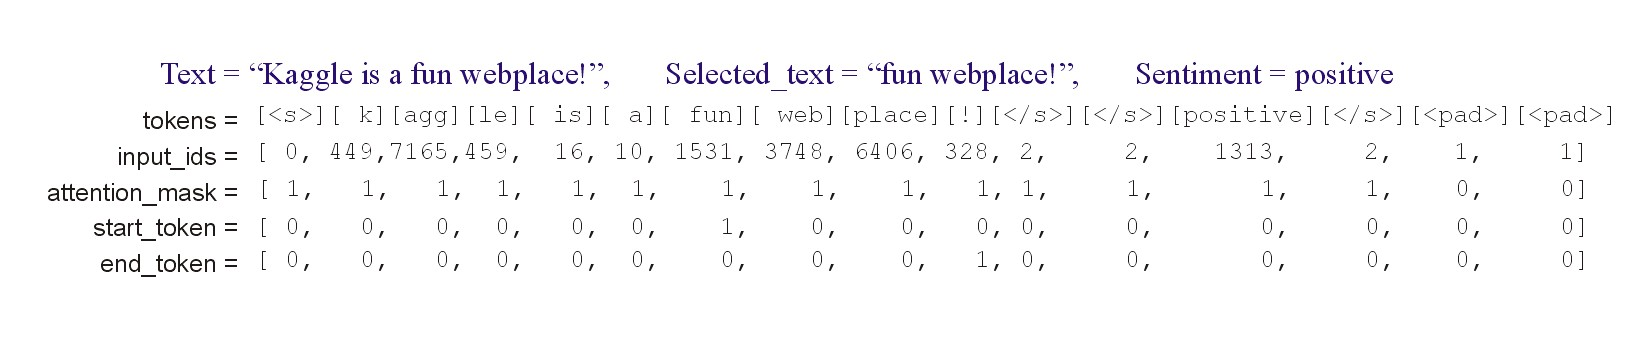


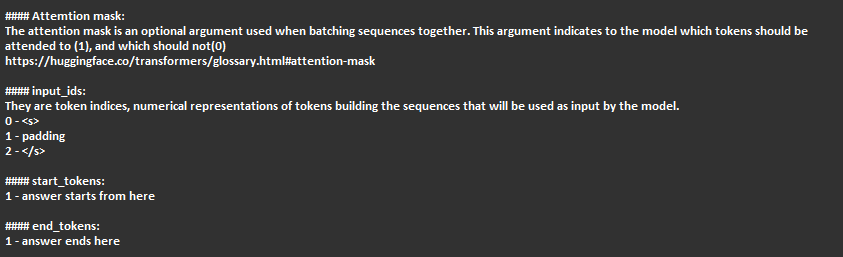

https://huggingface.co/transformers/glossary.html#attention-mask


### Encoding Train data:

In [ ]:
#tokenizer
PATH = '../input/tf-roberta/'

#ByteLevelBPETokenizer has some additional convenience features like lowercase=True and addprefixspace=True.Hence we are using this
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)

In [ ]:
# calculating length of the longest text

MAX_LEN = 0

for text in train['text']:

    # Tokenize the text and add special tokens i.e [`<s>]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    MAX_LEN = max(MAX_LEN, len(input_ids))


print('Max length: ', MAX_LEN)

In [ ]:
#sentiment encoding

sent = ['positive','negative','neutral']
sent_id =[]
for i in sent:
    sent_id.append(tokenizer.encode(i).ids[0])
sentiment_id = dict(zip(sent,sent_id))
sentiment_id

In [ ]:
#creating RoBERTa format inputs (input_ids,attention_mark,start_tokens,end_tokens)

ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # Finding overlap between text and selected_text
    text1 = " "+" ".join(train.loc[k,'text'].split())
#     print(k)
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ':
        chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
#     print(enc)
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START & END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1


### Encoding test data

In [ ]:
ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

### Build roBERTa Model (Custom question answer machine)

In [ ]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    #we have to target variables (start_token and end_token). hence we are creating two models to classify values(1 or 0) for these variables
    
    '''
    The Conv1D are essential because they preserve spatial information. We want our model to predict a start index and end index which are spatial.
    If you use GlobalAveragePooling1D you will lose spatial information. You will know which texts are positive, negative, neutral but you won't 
    know where the words are located.
    '''
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

#### Metric:

The metric in this competition is the word-level Jaccard score. Jaccard Score is a measure of how similar/dissimilar two sets are. The higher the score, the more similar the two strings. The idea is to find the number of common tokens and divide it by the total number of unique tokens. Its expressed in the mathematical terms by,
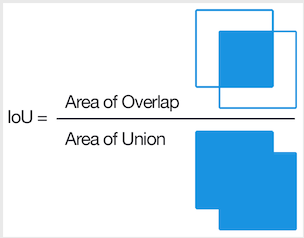
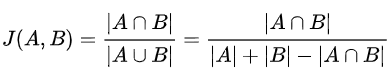

In [ ]:
#defining the metric

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))



### Training :

In [ ]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch') #to save best weights 
        
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=5, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]])) 
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

### Predicting:

In [ ]:
result= []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    result.append(st)
result[:5]

### Submission:

In [ ]:
test['selected_text'] = result
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.read_csv('submission.csv').head(10)

#### Special thanks to :
    1. Abhishek Thakur: https://www.kaggle.com/abhishek/roberta-inference-5-folds
    2. Mr_KnowNothing : https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model/notebook
    3. Parul Pandey : https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert/notebook
    4. Chris Deotte : https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705/notebook